In [ ]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.metrics import mean_squared_error
import operator
from random import randint, random, seed

seed(0)


# Read in data
data_1 = np.genfromtxt("data.txt",delimiter=",")
data_2 = np.genfromtxt("data_2.txt",delimiter=",")

df = pd.DataFrame(data_1,columns=["x","y"])
feature_names = ['x']
target_name = 'y'

data = df[feature_names]
target = df[target_name]

def safe_div(a, b):                                                                                  
    return a / b if b else a                                                                         
                              
def cos(a):
    return np.cos(a)

def sin(a):
    return np.sin(a)
def exp2(a):
    return a**2
def exp3(a):
    return a**3
def exp4(a):
    return a**4

operations = (                                                                                       
    {"func": operator.add, "arg_count": 2, "format_str": "({} + {})"},                               
    {"func": operator.sub, "arg_count": 2, "format_str": "({} - {})"},                               
    {"func": operator.mul, "arg_count": 2, "format_str": "({} * {})"},                               
    {"func": safe_div, "arg_count": 2, "format_str": "({} / {})"},                                   
    #{"func": operator.neg, "arg_count": 1, "format_str": "-({})"}  ,
    {"func": cos, "arg_count": 1, "format_str": "np.cos({})"},
    {"func": sin, "arg_count": 1, "format_str": "np.sin({})"},
    {"func": exp2, "arg_count": 1, "format_str": "({} ** 2)"},
    {"func": exp3, "arg_count": 1, "format_str": "({} ** 3)"},
    #{"func": exp4, "arg_count": 1, "format_str": "({} ** 4)"}    
)

features = ['x','x','x','x','x','x','x','x','x','x','x','x','x','x','x','x','x','x','x','x','x','x','x','x','x','x','x','x','x','x','x','x','x','x','x','x','x','x','x','x',1,2,3,4,5,6,7,8,9,10,-1,-2,-3,-4,-5,-6,-7,-8,-9,-10]
#features = ['x','x','x','x','x','x','x','x','x','x',1,2,3,4,5,6,7,8,9,10,-1,-2,-3,-4,-5,-6,-7,-8,-9,-10]

seed(0)

def random_prog(depth):                                                                              
    # favor adding function nodes near the tree root and 
    # leaf nodes as depth increases                           
    if randint(0, 10) >= depth*2:                                                                  
        op = operations[randint(0, len(operations) - 1)]                                             
        return {                                                                                     
            "func": op["func"],                                                                      
            "children": [random_prog(depth + 1) for _ in range(op["arg_count"])],                    
            "format_str": op["format_str"],                                                          
        }                                                                                            
    else:                                                                                            
        #return {"feature_name": X.columns[randint(0, X.shape[1] - 1)]}      
        return {"feature_name": features[randint(0, len(features) - 1)]} 

def render_prog(node):
    if "children" not in node:
        return node["feature_name"]
    return node["format_str"].format(*[render_prog(c) for c in node["children"]])

def evaluate(node, row):
    if "children" not in node:
        return row[node["feature_name"]]
    return node["func"](*[evaluate(c, row) for c in node["children"]])

def safe_div(a, b):
    return a / b if b else a



def random_prog(depth):
    # favor adding function nodes near the tree root and
    # leaf nodes as depth increases
    if randint(0, 10) >= depth * 2:
        op = operations[randint(0, len(operations) - 1)]
        return {
            "func": op["func"],
            "children": [random_prog(depth + 1) for _ in range(op["arg_count"])],
            "format_str": op["format_str"],
        }
    else:
        return {"feature_name": data.columns[randint(0, data.shape[1] - 1)]}



def select_random_node(selected, parent, depth):
    if "children" not in selected:
        return parent
    # favor nodes near the root
    if randint(0, 10) < 2*depth:
        return selected
    child_count = len(selected["children"])
    return select_random_node(
        selected["children"][randint(0, child_count - 1)],
        selected, depth+1)

from copy import deepcopy

def do_mutate(selected):
    offspring = deepcopy(selected)
    mutate_point = select_random_node(offspring, None, 0)
    child_count = len(mutate_point["children"])
    mutate_point["children"][randint(0, child_count - 1)] = random_prog(0)
    return offspring


def do_xover(selected1, selected2):
    offspring = deepcopy(selected1)
    xover_point1 = select_random_node(offspring, None, 0)
    xover_point2 = select_random_node(selected2, None, 0)
    child_count = len(xover_point1["children"])
    xover_point1["children"][randint(0, child_count - 1)] = xover_point2
    return offspring



def get_random_parent(population, fitness):
    # randomly select population members for the tournament
    tournament_members = [
        randint(0, POP_SIZE - 1) for _ in range(TOURNAMENT_SIZE)]
    # select tournament member with best fitness
    member_fitness = [(fitness[i], population[i]) for i in tournament_members]
    return max(member_fitness, key=lambda x: x[0])[1]

XOVER_PCT = 0.7

def get_offspring(population, fitness):
    parent1 = get_random_parent(population, fitness)
    if random() > XOVER_PCT:
        parent2 = get_random_parent(population, fitness)
        return do_xover(parent1, parent2)
    else:
        return do_mutate(parent1)

REG_STRENGTH = 0.5

def node_count(x):
    if "children" not in x:
        return 1
    return sum([node_count(c) for c in x["children"]])


def compute_fitness(program, prediction):
    mse = ((pd.Series(prediction) - target) ** 2).mean()
    penalty = node_count(program) ** REG_STRENGTH
    return mse * penalty

In [14]:
MAX_GENERATIONS = 50
POP_SIZE = 300
population = [random_prog(0) for _ in range(POP_SIZE)]
TOURNAMENT_SIZE = 50

output = []
global_best = 0
for gen in tqdm(range(MAX_GENERATIONS)):
    fitness = []
    for prog in tqdm(population):                                                                          
        y_pred = []
        data.reset_index(drop=True)
        eq = str(render_prog(prog)).replace(" ","")
        for i in range(len(data)):
            x = data.iloc[i]
            try:
                pred = float(eval(eq))
            except (SyntaxError, NameError, TypeError, ZeroDivisionError,OverflowError):
                pred = 0.0
            if type(pred)!=float:
                pred = pred['x']
            if pred == np.inf or pred == -np.inf or np.isnan(pred):
                pred = 0
            y_pred.append(pred)
        score = 1/(mean_squared_error(target, y_pred))#*node_count(prog)**REG_STRENGTH)
        fitness.append(score)
        if score > global_best:
            global_best = score
            best_prog = prog
            output.append((gen, prog, score, y_pred))
    print(
        "Generation: %d\nBest Score: %.2f\nMedian score: %.2f\nBest program: %s\n"
        % (
            gen,
            global_best,
            pd.Series(fitness).median(),
            render_prog(best_prog),
        )
    )
    population = [
        get_offspring(population, fitness)
        for _ in range(POP_SIZE)]

'''print("Best score: %f" % global_best)
print("Best program: %s" % render_prog(best_prog))
output = {"target": target, "pred": best_pred}
pd.DataFrame(output).to_csv("best_pred.csv")'''

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\envs\main\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sin
  result = getattr(ufunc, method)(*inputs, **kwargs)


Generation: 0
Best Score: 0.08
Median score: 0.02
Best program: (((x ** 3) / x) / ((((x + x) / x) / (x / x)) + x))



  0%|          | 0/300 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\envs\main\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sin
  result = getattr(ufunc, method)(*inputs, **kwargs)


Generation: 1
Best Score: 0.14
Median score: 0.02
Best program: (((x ** 3) / x) / ((((x + x) / x) / ((x + x) / (x * x))) + x))



  0%|          | 0/300 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\envs\main\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sin
  result = getattr(ufunc, method)(*inputs, **kwargs)


Generation: 2
Best Score: 0.16
Median score: 0.02
Best program: (((x ** 3) / x) / ((((x + x) / ((((x + x) / x) / ((x + x) / (x * x))) + x)) / ((x + x) / (x * x))) + x))



  0%|          | 0/300 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\envs\main\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sin
  result = getattr(ufunc, method)(*inputs, **kwargs)


Generation: 3
Best Score: 0.30
Median score: 0.02
Best program: ((((((x / x) + x) - np.sin(x)) ** 3) / x) / ((x - ((x + x) / x)) + ((((x + x) / x) / (x / x)) + (x + (x / (((x + x) - x) ** 2))))))



  0%|          | 0/300 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\envs\main\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sin
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\ProgramData\Anaconda3\envs\main\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in cos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Generation: 4
Best Score: 0.35
Median score: 0.02
Best program: ((((((x / x) + x) - np.sin(x)) ** 3) / x) / ((x - ((x + x) / (((np.sin(x) - x) ** 2) + x))) + ((((x + x) / x) / (x / x)) + (x + (x / (((x + x) - x) ** 2))))))



  0%|          | 0/300 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\envs\main\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in cos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Generation: 5
Best Score: 0.36
Median score: 0.02
Best program: ((((((x / x) + x) - np.sin(x)) ** 3) / x) / ((x - ((x + x) / (((((x + x) * (x / (x ** 2))) + ((x + x) - np.sin((x + x)))) ** 2) + x))) + ((((x + x) / x) / (x / x)) + (x + (x / (((x + x) - x) ** 2))))))



  0%|          | 0/300 [00:00<?, ?it/s]

Generation: 6
Best Score: 0.36
Median score: 0.02
Best program: ((((((x / x) + x) - np.sin(x)) ** 3) / x) / ((x - ((((x / ((x / x) ** 2)) / x) ** 2) / ((((x + (np.cos(x) ** 3)) / x) / ((x + x) / (x * x))) + x))) + ((((x + x) / x) / (x / x)) + ((x + (x / (((x + x) - x) ** 2))) + (x / (((x + x) - x) ** 2))))))



  0%|          | 0/300 [00:00<?, ?it/s]

Generation: 7
Best Score: 0.39
Median score: 0.02
Best program: ((((((x / x) + x) - np.sin(x)) ** 3) / x) / ((x - np.cos((x + (((np.sin(np.cos(x)) + (x ** 2)) + np.sin(x)) / (((x + x) - x) ** 2))))) + ((((x + x) / x) / (x / x)) + (x + (x / (((x + x) - x) ** 2))))))



  0%|          | 0/300 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\envs\main\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in cos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Generation: 8
Best Score: 0.39
Median score: 0.02
Best program: ((((((x / x) + x) - np.sin(x)) ** 3) / x) / ((x - np.cos((x + (((np.sin(np.cos(x)) + (x ** 2)) + np.sin(x)) / (((x + x) - x) ** 2))))) + ((((x + x) / x) / ((x - ((x + x) / (((((x + x) * (x / (x ** 2))) + ((x + x) - np.sin((x + x)))) ** 2) + ((((x / ((x / x) ** 2)) / x) ** 2) / x)))) / x)) + (x + (x / (((x + x) - x) ** 2))))))



  0%|          | 0/300 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\envs\main\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in cos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Generation: 9
Best Score: 0.40
Median score: 0.02
Best program: ((((((x / x) + (x - np.sin((x - np.sin(x))))) - np.sin(x)) ** 3) / x) / ((x - np.cos((x - np.cos((x + (((np.sin(np.cos(x)) + (x ** 2)) + np.sin(x)) / (((x + x) - x) ** 2))))))) + ((((x + x) / x) / (x / x)) + ((((x + x) / x) / (((x ** 3) / x) ** 3)) + (x + (x / (((x + x) - x) ** 2)))))))



  0%|          | 0/300 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\envs\main\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sin
  result = getattr(ufunc, method)(*inputs, **kwargs)


Generation: 10
Best Score: 0.41
Median score: 0.02
Best program: ((((((x / x) + (x - np.sin((x - np.sin(x))))) - np.sin(x)) ** 3) / x) / (((((x / x) + x) - np.sin(x)) - np.cos(((((x + x) / x) / (((x ** 3) / x) ** 3)) + (x + (x / (((x + x) - x) ** 2)))))) + ((((x + x) / x) / (x / x)) + ((((x + x) / x) / (((x ** 3) / x) ** 3)) + (x + (x / (((x + x) - x) ** 2)))))))



  0%|          | 0/300 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\envs\main\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in cos
  result = getattr(ufunc, method)(*inputs, **kwargs)


Generation: 11
Best Score: 0.43
Median score: 0.02
Best program: ((((((x / x) + (x - np.sin((x - np.sin(x))))) - np.sin(x)) ** 3) / x) / (((((x + x) / x) / (x / x)) + (((x + (x * (x ** 2))) - (x ** 3)) + (x / (((x + x) - x) ** 2)))) + ((((x + x) / x) / (x / x)) + ((((x + x) / x) / (((x ** 3) / x) ** 3)) + (x + (x / (((x + x) - x) ** 2)))))))



  0%|          | 0/300 [00:00<?, ?it/s]

C:\ProgramData\Anaconda3\envs\main\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sin
  result = getattr(ufunc, method)(*inputs, **kwargs)


KeyboardInterrupt: 

In [74]:
import multiprocessing as mp

In [69]:
p1 = multiprocessing.Process(target=gp_evolve, args=())
p2 = multiprocessing.Process(target=gp_evolve, args=())
p3 = multiprocessing.Process(target=gp_evolve, args=())
p4 = multiprocessing.Process(target=gp_evolve, args=())
p5 = multiprocessing.Process(target=gp_evolve, args=())

In [71]:
# starting process 1
p1.start()
# starting process 2
p2.start()
# starting process 3
p3.start()
# starting process 4
p4.start()
# starting process 5
p5.start()

In [73]:
p1.terminate()
p2.terminate()
p3.terminate()
p4.terminate()
p5.terminate()

In [78]:
pool = mp.Pool(processes=5)

results = []
for result in tqdm(pool.imap_unordered(gp_evolve)):
    results.append(result)

print(results)

TypeError: imap_unordered() missing 1 required positional argument: 'iterable'

In [ ]:
#Metrics for first run

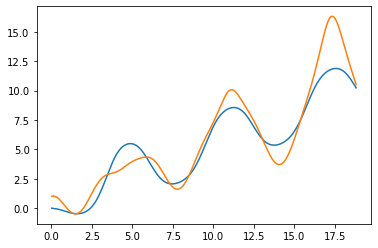

In [11]:
plt.plot(data_1[:,0],output[-1][3])
plt.plot(data_1[:,0],data_1[:,1])
plt.show()

In [9]:
import matplotlib.pyplot as plt

In [53]:
best_prog_run_1 = best_prog
best_pred_run_1 = best_pred
eq = render_prog(best_prog).replace(" ","")

In [12]:
#run2
run2_output = output

In [63]:
y_pred = []
for i in range(len(data)):
    x = data.iloc[i]
    try:
        pred = float(eval(render_prog(best_prog).replace(" ","")))
    except (SyntaxError, NameError, TypeError, ZeroDivisionError,OverflowError):
        pred = 0.0
    if type(pred)!=float:
        pred = pred['x']
    if pred == np.inf or pred == -np.inf or np.isnan(pred):
        pred = 0
    y_pred.append(pred)

In [47]:
y_pred

[0.24467420024818268,
 0.24557363098495655,
 0.27002525596137583,
 0.281689132534619,
 0.286278477075878,
 0.309901667714009,
 0.31039175000941543,
 0.3131012226070518,
 0.3162920264370038,
 0.33310563049744174,
 0.3369683655298163,
 0.3467432621665481,
 0.35379604941602794,
 0.35609404157879204,
 0.37366500575450945,
 0.37839705573818083,
 0.38248893909543935,
 0.4197553450890831,
 0.43123194396103726,
 0.4490379973301943,
 0.4540466505432081,
 0.4597390793357678,
 0.47001106643743346,
 0.48061519764141813,
 0.4850359352285829,
 0.4922117577308476,
 0.5141975711726124,
 0.5151273426184058,
 0.5220873563556587,
 0.523116299746424,
 0.5383161359696215,
 0.5397403522577822,
 0.5532301223163552,
 0.5571865209809193,
 0.5872613233040783,
 0.590031253579502,
 0.5904598449940722,
 0.6004097096110352,
 0.605010268156318,
 0.6106165932456888,
 0.6120297126510404,
 0.6133473755691348,
 0.6141631318302322,
 0.6416642173243265,
 0.6422902902713232,
 0.6537609266153458,
 0.6547173465179456,
 0.659